# Flora Prepper Model Evaluation
## Initialize the environment

In [1]:
import os
import sys

module_path = os.path.abspath(os.path.join('../'))
if module_path not in sys.path:
    sys.path.append(module_path)

from src.data.make_fna import *
from src.data.make_bc import *
from src.data.make_budds import *
from src.models.run_model import *
from src.visualization.visualize import *
from src.features.build_features import *
from src.features.build_length_features import *
from src.features.build_stop_words import *
from src.features.process_text import *
import numpy as np

## Import the data

In [2]:
fna = make_fna_data_frame(fna_filepath="../data/external/fna_with_habitat.csv", frac_to_sample=0.1, balance_categories=True,
                          categories_to_keep=["key", "morphology", "taxon_identification", 
                                              "distribution", "discussion", "habitat"])
bc = make_bc_data_frame(bc_filepath="../data/external/eflora-bc-full_no-id.csv",
                        frac_to_sample=0.13, balance_categories=True, 
                        categories_to_keep=["key", "morphology", "taxon_identification", "habitat", "discussion"])
budds = make_budds_data_frame(budds_file_path="../data/external/buddsfloraofcana00otta_djvu.xml", frac_to_sample=1,
                              balance_categories=True)
flora_data_frame = pd.concat([fna, bc, budds], keys=['fna', 'bc', 'budds'], names=['dataset_name', 'row_id'])

/Users/jocelynpender/miniconda3/envs/flora-prepper/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  if __name__ == '__main__':


## Visualize the data
### Visualize counts of training datasets

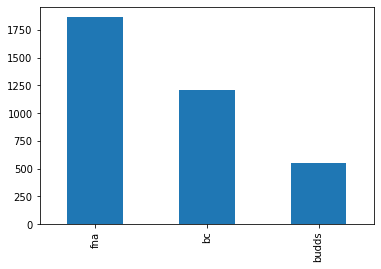

In [3]:
flora_data_frame = flora_data_frame.sample(frac=1) # Shuffle the dataset in place
flora_data_frame = flora_data_frame.reset_index()
flora_data_frame['dataset_name'].value_counts().plot.bar()
plt.show()

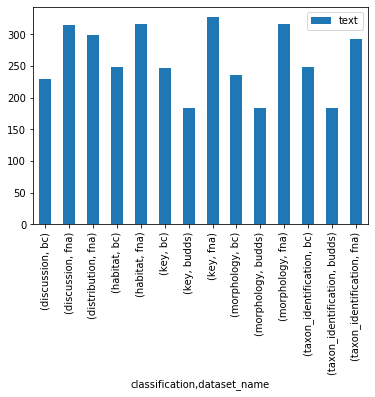

In [4]:
flora_data_frame[['classification', 'dataset_name', 'text']] \
.groupby(['classification', 'dataset_name']).count().plot.bar()


### View a word cloud for all text data 
Text is processed using the same custom (bare-bones) tokenizer and stopwords used to train the model. 


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jocelynpender/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


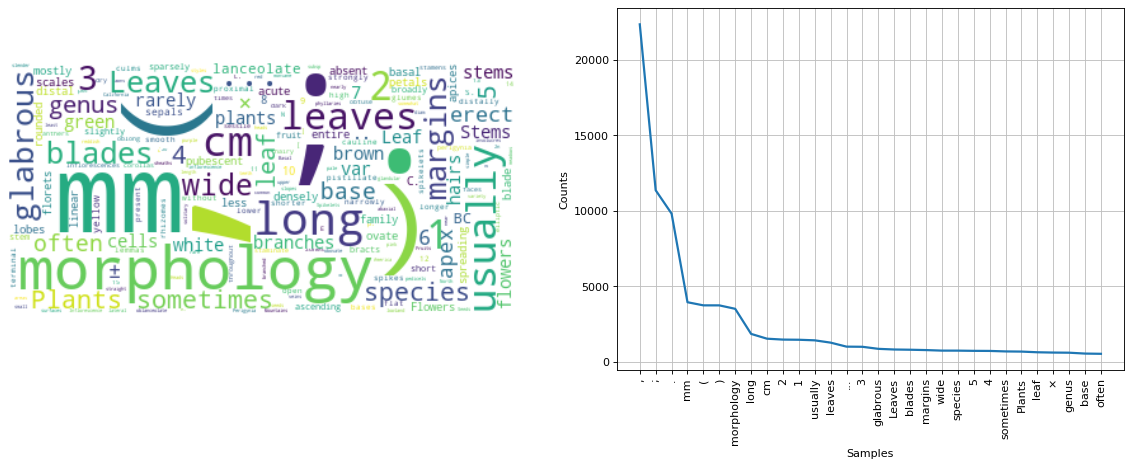

[(',', 22364), (';', 11371), ('.', 9823), ('mm', 3953), ('(', 3746), (')', 3745), ('morphology', 3517), ('long', 1855), ('cm', 1537), ('2', 1478), ('1', 1467), ('usually', 1429), ('leaves', 1276), ('...', 1011), ('3', 1001), ('glabrous', 865), ('Leaves', 821), ('blades', 806), ('margins', 783), ('wide', 747), ('species', 746), ('5', 732), ('4', 727), ('sometimes', 694), ('Plants', 683), ('leaf', 638), ('×', 618), ('genus', 609), ('base', 551), ('often', 536)]


In [5]:
tokenized_stop_words = prepare_stop_words(custom_stop_words=["unknown", "accepted", "synonym",
                                                             "basionym", "source",
                                                             "note", "notes"])  # Find a way to keep numbers and elipses!
text = " ".join(text_string for text_string in flora_data_frame.text)
visualize_words(text, tokenized_stop_words)

### Generate word clouds by classification.
Are there any noticeable differences between the words used most frequently between the classifications?

In [6]:
taxon_identification = " ".join(text_string for text_string in flora_data_frame[flora_data_frame.classification == "taxon_identification"].text)
morphology = " ".join(text_string for text_string in flora_data_frame[flora_data_frame.classification == "morphology"].text)
key = " ".join(text_string for text_string in flora_data_frame[flora_data_frame.classification == "key"].text)
habitat = " ".join(text_string for text_string in flora_data_frame[flora_data_frame.classification == "habitat"].text)

Taxon identification

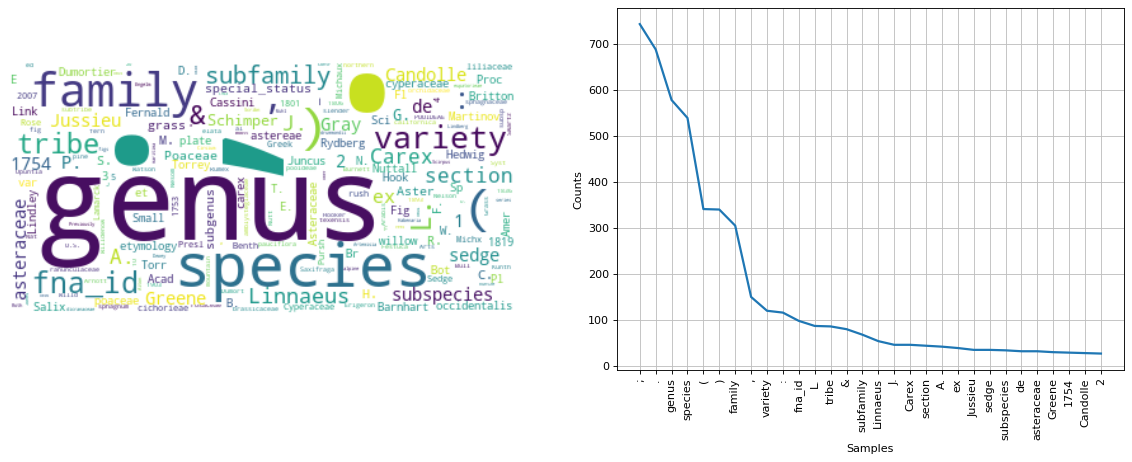

[(';', 743), ('.', 688), ('genus', 578), ('species', 539), ('(', 341), (')', 340), ('family', 305), (',', 150), ('variety', 120), (':', 116), ('fna_id', 98), ('L.', 87), ('tribe', 86), ('&', 80), ('subfamily', 68), ('Linnaeus', 54), ('J.', 46), ('Carex', 46), ('section', 44), ('A.', 42), ('ex', 39), ('Jussieu', 35), ('sedge', 35), ('subspecies', 34), ('de', 32), ('asteraceae', 32), ('Greene', 30), ('1754', 29), ('Candolle', 28), ('2', 27)]


In [7]:
visualize_words(taxon_identification, tokenized_stop_words)

Morphology

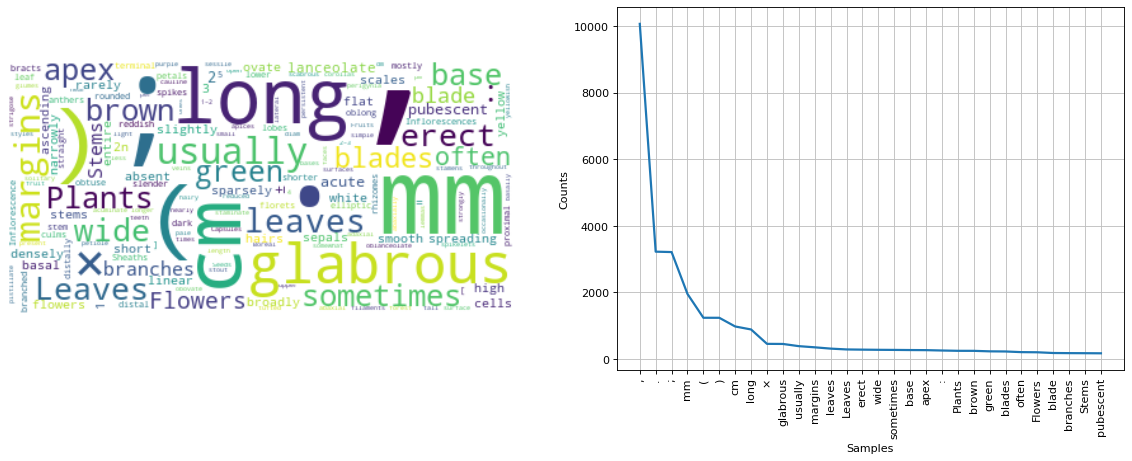

[(',', 10071), ('.', 3226), (';', 3214), ('mm', 1955), ('(', 1240), (')', 1239), ('cm', 978), ('long', 888), ('×', 456), ('glabrous', 453), ('usually', 387), ('margins', 352), ('leaves', 313), ('Leaves', 288), ('erect', 282), ('wide', 277), ('sometimes', 274), ('base', 270), ('apex', 267), (':', 256), ('Plants', 247), ('brown', 246), ('green', 231), ('blades', 227), ('often', 207), ('Flowers', 203), ('blade', 181), ('branches', 177), ('Stems', 175), ('pubescent', 172)]


In [8]:
visualize_words(morphology, tokenized_stop_words)

Keys

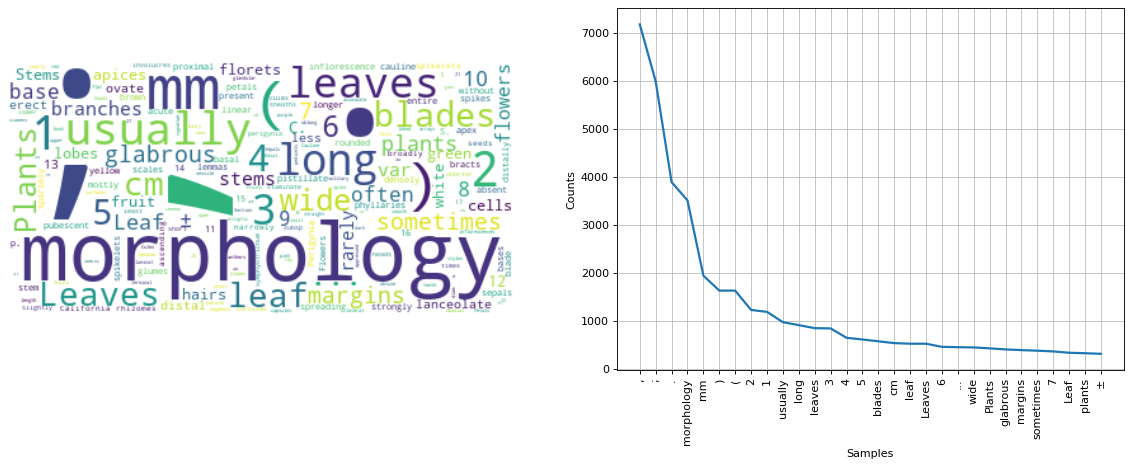

[(',', 7183), (';', 5994), ('.', 3892), ('morphology', 3509), ('mm', 1940), (')', 1628), ('(', 1627), ('2', 1224), ('1', 1184), ('usually', 969), ('long', 907), ('leaves', 844), ('3', 839), ('4', 643), ('5', 608), ('blades', 570), ('cm', 532), ('leaf', 520), ('Leaves', 519), ('6', 455), ('...', 447), ('wide', 442), ('Plants', 423), ('glabrous', 401), ('margins', 386), ('sometimes', 374), ('7', 359), ('Leaf', 331), ('plants', 321), ('±', 309)]


In [9]:
visualize_words(key, tokenized_stop_words)

Habitat

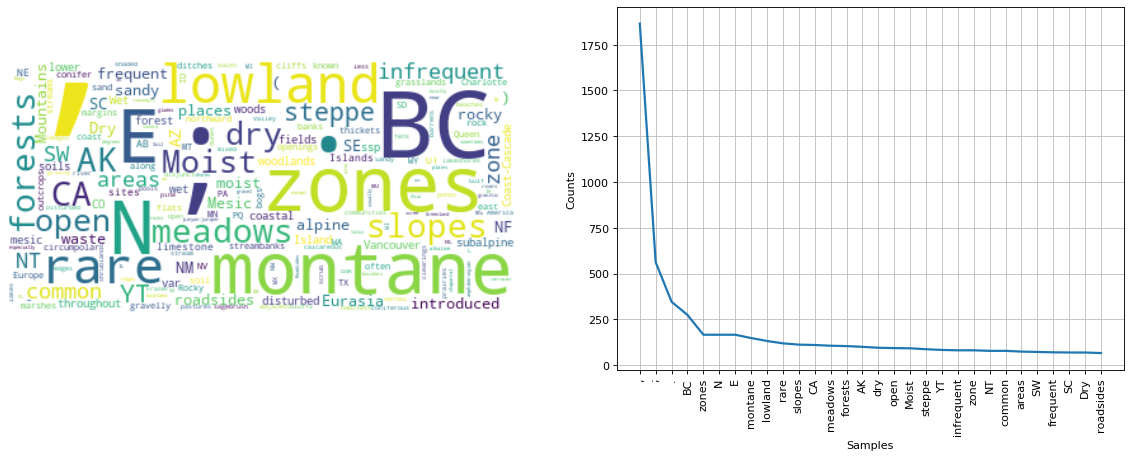

[(',', 1865), (';', 562), ('.', 346), ('BC', 274), ('zones', 166), ('N', 166), ('E', 166), ('montane', 148), ('lowland', 132), ('rare', 119), ('slopes', 112), ('CA', 110), ('meadows', 106), ('forests', 104), ('AK', 100), ('dry', 95), ('open', 93), ('Moist', 92), ('steppe', 87), ('YT', 83), ('infrequent', 81), ('zone', 81), ('NT', 78), ('common', 78), ('areas', 74), ('SW', 72), ('frequent', 70), ('SC', 69), ('Dry', 69), ('roadsides', 66)]


In [10]:
visualize_words(habitat, tokenized_stop_words)


### Word clouds by flora source
Are there differences between training sets in the most commonly used words?

In [11]:
bc_text = " ".join(text_string for text_string in bc.text if text_string not in tokenized_stop_words)
budds_text = " ".join(text_string for text_string in budds.text if text_string not in tokenized_stop_words)
fna_text = " ".join(text_string for text_string in fna.text if text_string not in tokenized_stop_words)


BC

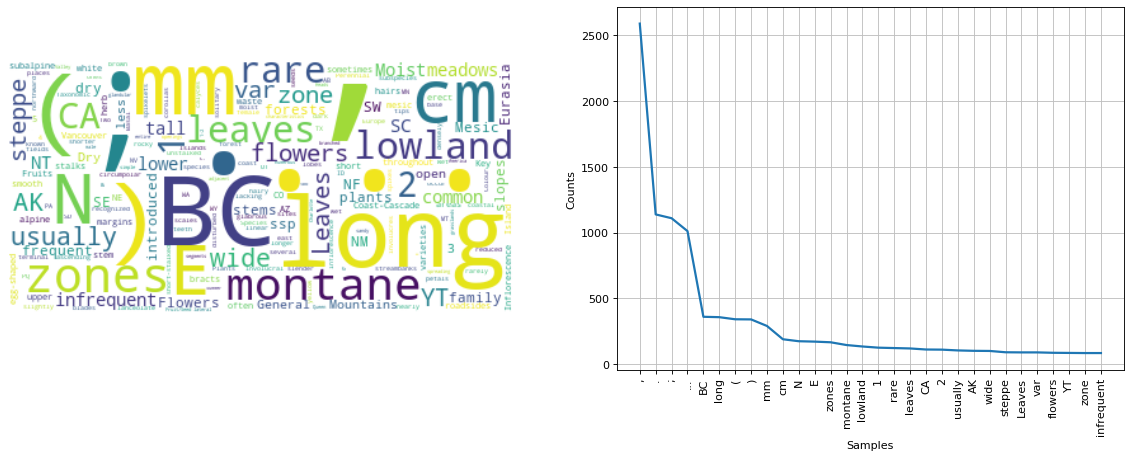

[(',', 2590), ('.', 1138), (';', 1109), ('...', 1011), ('BC', 359), ('long', 356), ('(', 340), (')', 339), ('mm', 289), ('cm', 188), ('N', 173), ('E', 170), ('zones', 165), ('montane', 144), ('lowland', 133), ('1', 124), ('rare', 121), ('leaves', 118), ('CA', 110), ('2', 109), ('usually', 103), ('AK', 100), ('wide', 99), ('steppe', 89), ('Leaves', 88), ('var', 88), ('flowers', 85), ('YT', 84), ('zone', 83), ('infrequent', 83)]


In [12]:
visualize_words(bc_text, tokenized_stop_words)

FNA

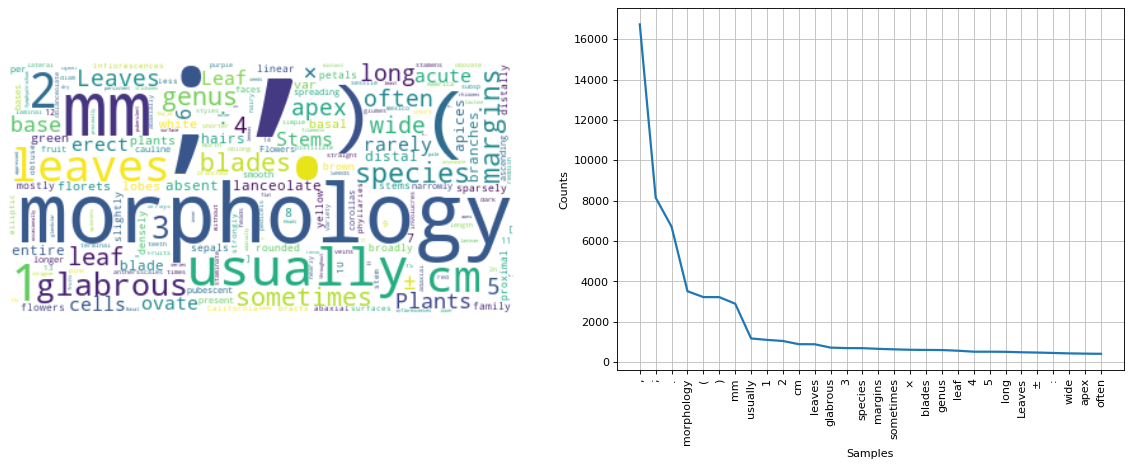

[(',', 16735), (';', 8149), ('.', 6712), ('morphology', 3517), ('(', 3226), (')', 3225), ('mm', 2899), ('usually', 1178), ('1', 1108), ('2', 1053), ('cm', 894), ('leaves', 891), ('glabrous', 725), ('3', 700), ('species', 697), ('margins', 664), ('sometimes', 639), ('×', 618), ('blades', 610), ('genus', 604), ('leaf', 571), ('4', 523), ('5', 522), ('long', 517), ('Leaves', 494), ('±', 480), (':', 459), ('wide', 439), ('apex', 426), ('often', 418)]


In [13]:
visualize_words(fna_text, tokenized_stop_words)

Budds

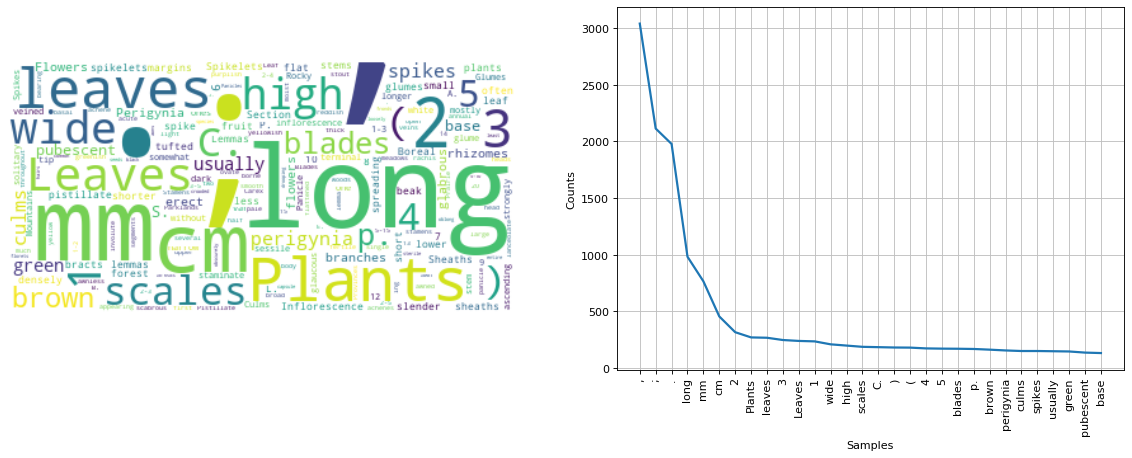

[(',', 3039), (';', 2113), ('.', 1977), ('long', 982), ('mm', 765), ('cm', 455), ('2', 316), ('Plants', 270), ('leaves', 267), ('3', 247), ('Leaves', 239), ('1', 235), ('wide', 209), ('high', 198), ('scales', 187), ('C.', 184), (')', 181), ('(', 180), ('4', 173), ('5', 171), ('blades', 170), ('p.', 168), ('brown', 162), ('perigynia', 155), ('culms', 150), ('spikes', 150), ('usually', 148), ('green', 146), ('pubescent', 136), ('base', 132)]


In [14]:
visualize_words(budds_text, tokenized_stop_words)


### What happens to the key and morphology classifications if we implement stricter word tokenization?

Key

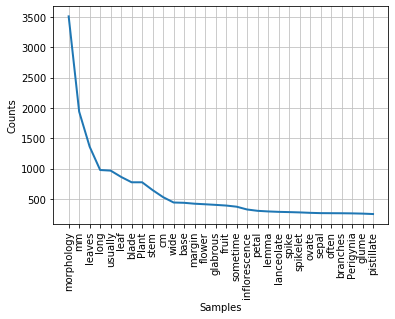

In [15]:
word_cloud_key = WordCloud(stopwords=tokenized_stop_words, 
                      background_color="white", collocations=False).process_text(key)
fdist_key = FreqDist(word_cloud_key)
fdist_key.plot(30,cumulative=False)
plt.show()

Morphology

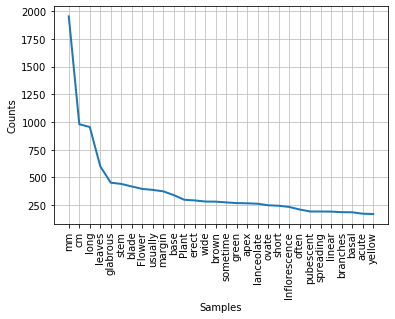

In [16]:
word_cloud_morphology = WordCloud(stopwords=tokenized_stop_words, 
                      background_color="white", collocations=False).process_text(morphology)
fdist_morphology = FreqDist(word_cloud_morphology)
fdist_morphology.plot(30,cumulative=False)
plt.show()

### Visualize distinctive words using tf-idf


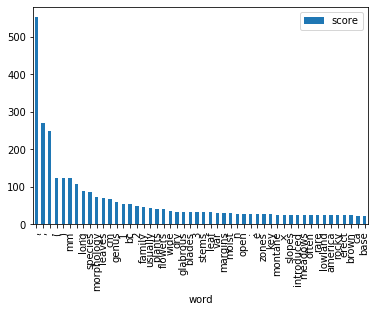

In [17]:
custom_vec = TfidfVectorizer(lowercase=True, tokenizer=flora_tokenizer, stop_words=tokenized_stop_words, ngram_range=(1, 1))
text_counts = custom_vec.fit_transform(flora_data_frame['text'])  # Build TF-IDF Matrix

scores = zip(custom_vec.get_feature_names(), np.asarray(text_counts.sum(axis=0)).ravel())
sorted_scores = sorted(scores, key=lambda x: x[1], reverse=True)
#for item in sorted_scores:
 #   print("{0:10} Score: {1}".format(item[0], item[1]))
    
sorted_scores_df = pd.DataFrame(sorted_scores, columns=['word', 'score']).iloc[:50]
sorted_scores_df.plot.bar(x='word', y='score')
plt.show()

## Run a DTM based model and a TFIDF based model and review accuracy

In [18]:
# ==== DTM =====
dtm_text_counts = build_dtm_text_counts(flora_tokenizer, tokenized_stop_words, flora_data_frame)
dtm_X_test, dtm_predictions = run_model(dtm_text_counts, flora_data_frame)

# ==== TFIDF =====
tfidf_text_counts = build_tfidf_text_counts(flora_tokenizer, tokenized_stop_words, flora_data_frame)
tfidf_X_test, tfidf_predictions = run_model(tfidf_text_counts, flora_data_frame)


MultinomialNB Accuracy: 0.8639705882352942
MultinomialNB Accuracy: 0.8363970588235294


#### View classified statements

In [19]:
results = zip(dtm_X_test, dtm_predictions)
print(tuple(results))

((<1x15429 sparse matrix of type '<class 'numpy.int64'>'
	with 7 stored elements in Compressed Sparse Row format>, 'taxon_identification'), (<1x15429 sparse matrix of type '<class 'numpy.int64'>'
	with 16 stored elements in Compressed Sparse Row format>, 'habitat'), (<1x15429 sparse matrix of type '<class 'numpy.int64'>'
	with 11 stored elements in Compressed Sparse Row format>, 'habitat'), (<1x15429 sparse matrix of type '<class 'numpy.int64'>'
	with 6 stored elements in Compressed Sparse Row format>, 'key'), (<1x15429 sparse matrix of type '<class 'numpy.int64'>'
	with 94 stored elements in Compressed Sparse Row format>, 'key'), (<1x15429 sparse matrix of type '<class 'numpy.int64'>'
	with 11 stored elements in Compressed Sparse Row format>, 'distribution'), (<1x15429 sparse matrix of type '<class 'numpy.int64'>'
	with 17 stored elements in Compressed Sparse Row format>, 'distribution'), (<1x15429 sparse matrix of type '<class 'numpy.int64'>'
	with 52 stored elements in Compressed Sp

In [20]:
# TODO: View incorrectly classified statements

# Currently not working

#for item, labels in zip(X_test, predictions):
 #   print('%s => %s' % (item, ', '.join(flora_data_frame.classification[x] for x in labels)))

## Run a model based on text length

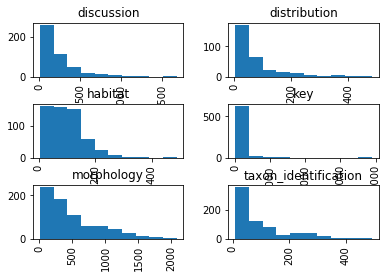

In [21]:
# Process text, remove stopwords. Remove empty cells.
length_processed_flora_data_frame = process_length_in_place(flora_data_frame, tokenized_stop_words)

plot = length_processed_flora_data_frame['length'].hist(by=length_processed_flora_data_frame['classification'])
plt.show()

It looks like discussion should be removed from the dataset. It is curiously short in length. This may be an artifact from the bc dataset.

In [22]:
length_custom_vec = CountVectorizer(lowercase=True, tokenizer=flora_tokenizer, stop_words=tokenized_stop_words,
                                 ngram_range=(1, 1))
length_text_counts = length_custom_vec.fit_transform(length_processed_flora_data_frame['text'])

length_model_sparse = prepare_length_features(length_text_counts, length_custom_vec, length_processed_flora_data_frame)

X_test, predicted = run_model(length_model_sparse, length_processed_flora_data_frame)

MultinomialNB Accuracy: 0.862475442043222


In [23]:
#fig,ax = plt.subplots(figsize=(5,5))
#plt.boxplot(df_train_1.phrase_len)
#plt.show()


To do plots:
classification coloured by source

## Run a model with only the most frequently occuring words

In [24]:
length_processed_flora_data_frame['text']

0       Shallow streams, ponds, wet moist meadows, str...
1                                   Key Species Taxonomic
2                             Species ca . 244 (7 flora).
3                                  1 . Plants perennials.
4       1 Petals flaring blade claw , 2-2.8 (-3.6) mm;...
                              ...                        
3620    Plants sod-forming tufted, culms 30-60 cm high...
3621                        Evergreen deciduous woodlands
3622    Young stems loosely tomentulose, tardily glabr...
3623    Sunny, open places, dry humid, often rocky san...
3624    1 . Perigynia much flattened, thin, scale-like...
Name: text, Length: 3392, dtype: object

In [27]:
flora_data_frame[flora_data_frame.classification == "taxon_identification"]

,dataset_name,row_id,classification,length,row,species,text
5,budds,395,taxon_identification,48,148.0,NaN,Ruppia occidentalis S. Wats . western ditch-grass
13,fna,8891,taxon_identification,208,NaN,NaN,liliaceae family Jussieu brodiaea genus Smith ...
14,fna,7244,taxon_identification,269,NaN,NaN,sapotaceae family Jussieu MANILKARA genus Adan...
17,bc,5245,taxon_identification,2,NaN,Carex praticola,
19,fna,8055,taxon_identification,230,NaN,NaN,cryphaeaceae family Schimper cryphaea genus D....
...,...,...,...,...,...,...,...
3594,fna,9012,taxon_identification,140,NaN,NaN,Haplopappus genus gooddingii species (A. Nelso...
3605,bc,4582,taxon_identification,46,NaN,Eriophorum viridicarinatum,Eriophorum viridicarinatum (Engelm .) Fernald
3611,bc,4650,taxon_identification,2,NaN,Salicornia rubra,
3612,budds,445,taxon_identification,37,375.0,NaN,Poa epilis Scribn . skyline blue grass


In [28]:
all_text = " ".join(text_string for text_string in flora_data_frame.text)
top_words_text = find_most_frequent_words(all_text)

all_text_processed = process_text(all_text, tokenized_stop_words, top_words=top_words_text)
#word_features = find_most_frequent_words(all_text_processed)
#all_text_custom_vec = CountVectorizer(lowercase=True, tokenizer=flora_tokenizer, stop_words=tokenized_stop_words,
                                 ngram_range=(1, 1))
#all_text_counts = all_text_custom_vec.fit_transform(word_features)
#X_test, predicted = run_model(all_text_counts, flora_data_frame)

ValueError: Found input variables with inconsistent numbers of samples: [2000, 3625]

In [29]:
all_text_counts

<2000x1890 sparse matrix of type '<class 'numpy.int64'>'
	with 2027 stored elements in Compressed Sparse Row format>

In [30]:
flora_data_frame

,dataset_name,row_id,classification,length,row,species,text
0,bc,5864,habitat,261,NaN,Hippuris montana,"Shallow streams, ponds, wet moist meadows, str..."
1,bc,863,key,40,NaN,Symphoricarpos albus var. albus,Key Species Taxonomic
2,fna,14389,discussion,33,NaN,NaN,Species ca . 244 (7 flora).
3,bc,1332,key,24,NaN,,1 . Plants perennials.
4,fna,2641,key,545,NaN,NaN,"1 Petals flaring blade claw , 2-2.8 (-3.6) mm;..."
...,...,...,...,...,...,...,...
3620,budds,207,morphology,458,341.0,NaN,"Plants sod-forming tufted, culms 30-60 cm high..."
3621,fna,16966,habitat,33,NaN,NaN,Evergreen deciduous woodlands
3622,fna,6086,morphology,603,NaN,NaN,"Young stems loosely tomentulose, tardily glabr..."
3623,fna,15591,habitat,62,NaN,NaN,"Sunny, open places, dry humid, often rocky san..."


In [ ]:
featuresets = [(document_features(d), c) for (d,c) in documents]
train_set, test_set = featuresets[100:], featuresets[:100]
classifier = nltk.NaiveBayesClassifier.train(train_set)